In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d ssismasterchief/machine-hack-fake-news-content-detection

  0% 0.00/560k [00:00<?, ?B/s]
100% 560k/560k [00:00<00:00, 90.4MB/s]


In [2]:
!unzip machine-hack-fake-news-content-detection.zip

Archive:  machine-hack-fake-news-content-detection.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample submission.csv   


In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
from tqdm import tqdm
tqdm.pandas()

In [4]:
import nltk
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [5]:
df = pd.read_csv("Train.csv")

In [6]:
df.shape
df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


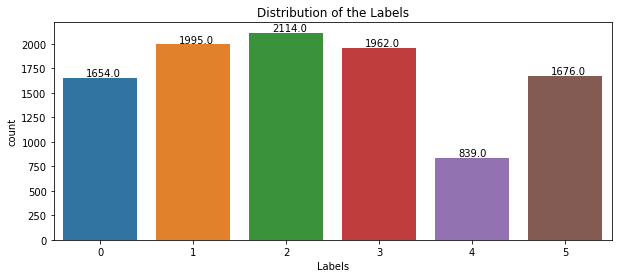

In [7]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x="Labels", data=df)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels")
plt.show()

**Preprocessing Data**

In [8]:
df['Original Text'] = df['Text']

In [9]:
print("Original text: ")

print(df['Text'][0])

Original text: 
Says the Annies List political group supports third-trimester abortions on demand.


In [10]:
df["Text"] = df["Text"].str.lower()

In [11]:
stopwords_ = set(stopwords.words('english'))

def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
df['Text'] = df['Text'].progress_apply(lambda text: stopwords_removal(text))

100%|██████████| 10240/10240 [00:00<00:00, 151133.86it/s]


In [12]:
print("After removing stopwords: ")

print(df['Text'][0])

After removing stopwords: 
says annies list political group supports third-trimester abortions demand.


In [13]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Text'] = df['Text'].progress_apply(lambda text: cleaning_punctuations(text))

100%|██████████| 10240/10240 [00:00<00:00, 180827.02it/s]


In [14]:
print("After removing punctuations: ")

print(df['Text'][0])

After removing punctuations: 
says annies list political group supports thirdtrimester abortions demand


**WordCloud**

In [15]:
from wordcloud import WordCloud

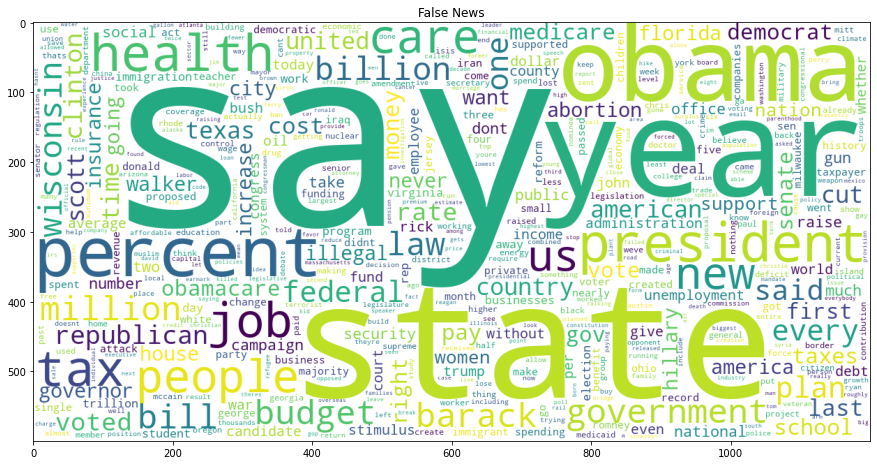

In [16]:
wc = WordCloud(background_color='white', max_words = 500 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(df[df['Labels']==1]['Text']))
plt.figure(figsize = (15,15))
plt.title("False News")
plt.imshow(wc)

**Preparation Of Data**

In [18]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [19]:
num_classes = (df['Labels'].nunique())

In [20]:
X = df['Text']
y = tf.keras.utils.to_categorical(df['Labels'], num_classes)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [24]:
vocab_length = len(train_word_index) + 1
vocab_length

12087

In [25]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [26]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [27]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

**Model**

In [28]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             72522     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [29]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

Epoch 1/20
256/256 [==============================] - 9s 18ms/step - loss: 1.7752 - f1_score: 0.1448 - val_loss: 1.7631 - val_f1_score: 0.0738
Epoch 2/20
256/256 [==============================] - 5s 21ms/step - loss: 1.7475 - f1_score: 0.1736 - val_loss: 1.7759 - val_f1_score: 0.1495
Epoch 3/20
256/256 [==============================] - 5s 21ms/step - loss: 1.6734 - f1_score: 0.2403 - val_loss: 1.8105 - val_f1_score: 0.1622
Epoch 4/20
256/256 [==============================] - 4s 16ms/step - loss: 1.4829 - f1_score: 0.3778 - val_loss: 1.9425 - val_f1_score: 0.1681
Epoch 5/20
256/256 [==============================] - 4s 16ms/step - loss: 1.2068 - f1_score: 0.5313 - val_loss: 2.1562 - val_f1_score: 0.1750
Epoch 6/20
256/256 [==============================] - 4s 16ms/step - loss: 0.9520 - f1_score: 0.6554 - val_loss: 2.5435 - val_f1_score: 0.1729
Epoch 7/20
256/256 [==============================] - 4s 16ms/step - loss: 0.7436 - f1_score: 0.7405 - val_loss: 2.8894 - val_f1_score: 0.1781

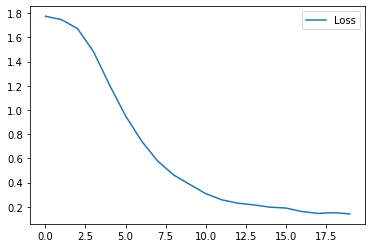

In [30]:
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.show()

In [31]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 0s 6ms/step - loss: 4.9511 - f1_score: 0.1774


[4.951114177703857,
 array([0.15455951, 0.18089172, 0.1972973 , 0.21614908, 0.12957747,
        0.18586387], dtype=float32)]

In [32]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

64/64 [==============================] - 1s 5ms/step


**Perfomance of model**


In [33]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix

In [34]:
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 4.951113406554427


In [35]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.1793427494869565


In [36]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
cm = multilabel_confusion_matrix(y_test, test_pred)

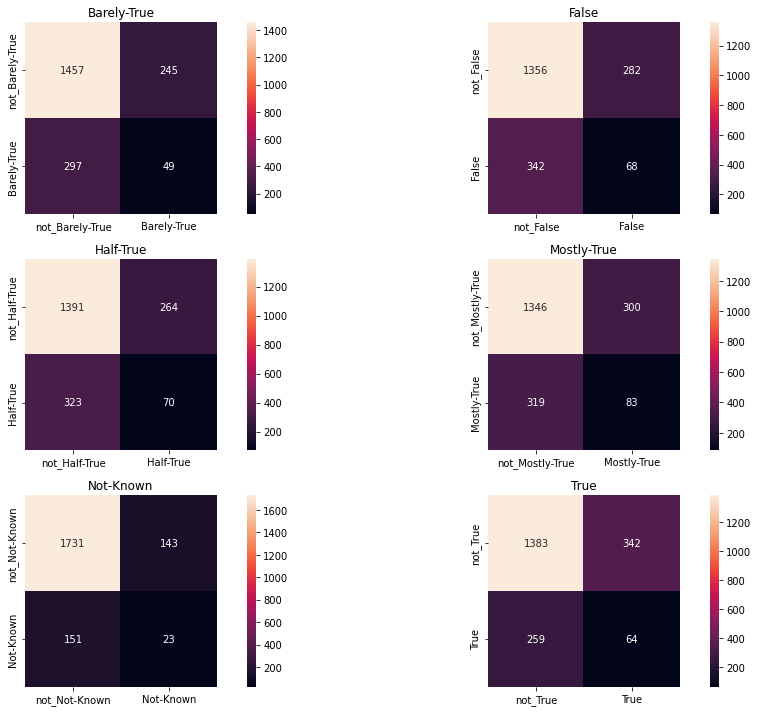

In [38]:
ig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()